# Estimation of Undiscovered Deposits in Quantitative Mineral Resource Assessments

## Objetivos

El objetivo de esta aplicación est tener una descripción estadística y exploratoria completa de los modelos numéricos de yacimiento desarrollados por el USGS.

### Grade and tonnage model.
Ideally, the data should be the estimated premining tonnages and grades.

In [1]:
## Librerias

import pandas as pd
import numpy as np
from numpy import random
from math import log

# Visualizations
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

#Distribucion Normal
from scipy.stats import norm, kstest
from scipy import stats

#Test de normalidad
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import shapiro, pearsonr

#
from termcolor import colored, cprint

plt.style.use('seaborn')

ModuleNotFoundError: No module named 'termcolor'

## Measure Units Conversions

1 troy ounce equals 31.103481 grams per ton, which equals 34.2857 grams per tonne. As 1 gram equals 0.0321492 troy ounces, the conversion factor is calculated as: 0.0321492 / 34.2857 x 31.103481 = 0.0291652 (rounded 0.029).



Although mineral values are often expressed in tonne, sometimes they are expressed by ton as well. As 1 ton equals 907.18474 kilograms and 1 tonne equals 1,000 kilograms, just remember the difference between tonne and ton is approximately 10% (mnemonic: less letters, less outcome).

Converting to SI units, 1 oz/ton equals 31.10 g (1 oz troy) per 0.9072 tonne (1 short ton), which multiplies out as 34.28 g/t.


### How to Convert Grades
 

 Percent grade |	Grams per ton | ppm | 	ppb 
 --- | --- | --- | --- 
 1.00%	= |	10,000gpt	= |	10,000ppm	= |	10,000,000ppb 
0.1%	= |	1 ,000gpt	= |	1,000ppm	= |	1,000,000ppb
0.01%	= |	100gpt	= |	100ppm	= |	100,000ppb
0.001%	= |	10gpt	= |	10ppm	= |	10,000ppb
0.000,1%	= |	1gpt	= |	1ppm	= |	1,000ppb
0.000,01%	= |	0.1gpt	= |	0.1ppm	= |	100ppb
 
Abbreviation	Unit	Equivalents

oz = 31.103 g

(Troy) ounce (also 'ozt')

> A common ounce is known as an avoir dupois ounce, and is 28.34g. Troy ounces are only used for precious metals, gems and gunpowder, but are 10% larger,  1 Troy oz is 31.1034768 g, and is either referred to as 'oz' or 'ozt'. Since all gold ounces are troy ounces, if 'oz' is used with gold, it refers to the Troy ounce. To make things extra complex, a Troy pound is smaller than a common 'pound', because it only contains 12 troy ounces, not 16 oz, as the avoir dupois 'common' pound does. The troy pound is 373.24 g, while an avoirdupois pound is 453.59g.

In [ ]:
#Conversiones entre medidas

def troyOunces2gram(ounces):
    return onces / 31.103481

def gram2troyOunces(grams):
    return grams * 31.103481

def ouncesTonne2gramTonne(gradeOunces):
    return gradeOunces / 0.0291652

def gramTonne2ouncesTonne(gradeGrams):
    return gradeGrams * 0.0291652

def tonne2ton(tnn):
    return tnn /  907.18474

def ton2tonne(t):
    return tn *  907.18474

def percent2gramTonne(gradePercent):
    return gradePercent * 10000

def percent2ouncesTonne(gradePercent):
    return gradePercent * 10000 * 0.0291652


def TaylorRuleofYacLife(t):
    '''
    Regla de Taylor para el cálculo de la vida del yacimiento
    t = Tonneage
    '''
    return 0.2 * ( t ** 0.25 )

In [ ]:
def freedman_diaconis(data, returnas="width"):
    """
    Use Freedman Diaconis rule to compute optimal histogram bin width. 
    ``returnas`` can be one of "width" or "bins", indicating whether
    the bin width or number of bins should be returned respectively. 


    Parameters
    ----------
    data: np.ndarray
        One-dimensional array.

    returnas: {"width", "bins"}
        If "width", return the estimated width for each histogram bin. 
        If "bins", return the number of bins suggested by rule.
    """
    data = np.asarray(data, dtype=np.float_)
    IQR  = stats.iqr(data, rng=(25, 75), scale="raw", nan_policy="omit")
    N    = data.size
    bw   = (2 * IQR) / np.power(N, 1/3)

    if returnas=="width":
        result = bw
    else:
        datmin, datmax = data.min(), data.max()
        datrng = datmax - datmin
        result = int((datrng / bw) + 1)
        
    return(result)

In [ ]:
#Clasificador por categorias mayor menor-igual
def classBySteps(x, stepLst):
    groupNdx  = 0
    groupName = ''
    for i in range(len(stepLst)-1):
        if x > stepLst[i] and x <= stepLst[i+1]:
            groupNdx = i
            groupName = str(stepLst[i]) + "-" + str(stepLst[i+1])
        elif i == 0:
            groupNdx = i
            groupName = str(stepLst[i]) + "-" + str(stepLst[i+1])
        
    
    return (groupNdx, groupName)

In [ ]:
def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    
    This function plots the confidence ellipse of the covariance of the given array-like variables x and y.
    The ellipse is plotted into the given axes-object ax.
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

In [2]:
def std_ellipse(x, y, ax, n_std=1, facecolor='none', **kwargs):
    """
    Create a plot of the standar desviation ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    
    
    """
    # two-dimensionl dataset.

    
    ellipse = Ellipse((np.mean(x), np.mean(y)), width=np.std(x) * 2 , height=np.std(y) * 2,
                      facecolor=facecolor, **kwargs)

    return ax.add_patch(ellipse)

# Modelado Numérico de Depósitos

In [3]:
# Ingresar Modelo de Depósito

depModelDF = pd.read_csv("../data/25b.csv")

# Ingresar Densidad Tabulada de depósitos
# 0.00485  depósitos / Km2 modelo 25b

depDensity = 0.00485


In [4]:
depModelDF.head()

,yacName,Loc,tonn,Au,Ag,Cu,Pb,Zn
0,ANIMAS,USA,8500000.0,0.00034,0.0099,0.45,2.0,300.0
1,BONANZA,USA,508000.0,0.00010,0.0237,1.20,2.6,230.0
2,CASAPALCA,PERU,17000000.0,0.00010,0.0161,0.30,1.8,3500.0
3,CHAVIN,PERU,315000.0,0.00000,0.0125,0.80,8.0,12500.0
4,COCO MINA,NICA,10300000.0,0.00017,0.0026,0.00,0.0,3400.0


In [5]:
#Definir la lista de menas a estudiar

menasLst   = ['Au', 'Ag', 'Cu', 'Pb']
#menasLst   = ['Au','Ag']

## Parametros Estadísticos

In [6]:
columName    = "tonn"
depModelTonn = depModelDF.loc[depModelDF[columName] > 0 ][columName] #Filtrar datos diferentes de cero
depModelPob  = depModelTonn.size
depModelMin  = depModelTonn.min()
depModelMax  = depModelTonn.max()
depModelMean = depModelTonn.mean()


print(f"Población: {depModelPob}")
#print(f"Min: {depModelMin:,.2f}T, Max: {depModelMax:,.2f}T")
print(f"Min: {depModelMin:,}%, Max: {depModelMax:,}%")
#print(f"Media sólo como referencia: {depModelMean:,.2f}T por si la distribución es log") #Este valor no tiene sentido porque la distribución es log
print(f"Media sólo como referencia: {depModelMean:,.10f} por si la distribución es log") #Este valor no tiene sentido porque la distribución es log


Población: 27
Min: 24,000.0%, Max: 107,000,000.0%
Media sólo como referencia: 8,191,518.5185185187 por si la distribución es log


### Exploración Valores máximos

In [7]:
depModelDF.loc[depModelDF['tonn'].idxmax()]


yacName    PACHUCA-R d MONTE
Loc                     MEXI
tonn             107000000.0
Au                   0.00022
Ag                    0.0461
Cu                      0.04
Pb                       0.2
Zn                     750.0
Name: 18, dtype: object

In [8]:
#Valores máximos de ley
for mena in menasLst:
    qResult = depModelDF.loc[depModelDF[mena].idxmax()]
    print(f'Yacimiento con Mejor ley {mena}')
    print(qResult)
    print()
    

Yacimiento con Mejor ley Au
yacName    URUACHIC
Loc            MEXI
tonn        33000.0
Au           0.0032
Ag            0.136
Cu             0.15
Pb              1.6
Zn            200.0
Name: 25, dtype: object

Yacimiento con Mejor ley Ag
yacName    URUACHIC
Loc            MEXI
tonn        33000.0
Au           0.0032
Ag            0.136
Cu             0.15
Pb              1.6
Zn            200.0
Name: 25, dtype: object

Yacimiento con Mejor ley Cu
yacName         SAI
Loc            JAPA
tonn       111000.0
Au          0.00003
Ag           0.0091
Cu              2.3
Pb              0.0
Zn           2200.0
Name: 21, dtype: object

Yacimiento con Mejor ley Pb
yacName      CHAVIN
Loc            PERU
tonn       315000.0
Au              0.0
Ag           0.0125
Cu              0.8
Pb              8.0
Zn          12500.0
Name: 3, dtype: object



### Distribución del Modelo de Depósito (tonelaje)

Comprobamos gráficamente de que se trata de una distribución logaritmica

In [9]:
n_bins = freedman_diaconis(depModelTonn, returnas='bins')

fig, ax = plt.subplots(figsize=(8,4))

# Overlay a reversed cumulative histogram.
ax.hist(depModelTonn, 
        bins=n_bins, 
        density=True, 
        histtype='stepfilled', 
        cumulative=0
        #label='Low Suphidation Au Qrtz Veins'
       )

# tidy up the figure
ax.grid(True)
#ax.legend(loc='right')
ax.set_title('Histograma')
ax.set_xlabel('Tonelaje')
ax.set_ylabel('Proporción de Depósitos')

plt.show()

NameError: name 'freedman_diaconis' is not defined

## Estadísticos Según la Transformada Logarítmica

In [10]:
'''
Deposit density is number of deposits by 1.000 square km
'''
depModelTonnLog         = np.log10(depModelTonn)

depModelTonnPob         = depModelTonnLog.size
depModelTonnLogMin      = depModelTonnLog.min()
depModelTonnLogMax      = depModelTonnLog.max()
depModelTonnLogMean     = depModelTonnLog.mean()
depModelTonnLogMean2dec = 10 ** depModelTonnLogMean
depModelTonnLogStd      = depModelTonnLog.std()
depModelTonnLog10p      = depModelTonnLog.quantile(.10)
depModelTonnLog50p      = depModelTonnLog.quantile(.50)
depModelTonnLog90p      = depModelTonnLog.quantile(.90)

#Habria que hacer el test de normalidad para aplicar este criterio

print(f"Población: {depModelTonnPob}")
print(f"Min: {depModelTonnLogMin:.2f} log(T), Max: {depModelTonnLogMax:.2f} log(T)")
print(f"Media: {depModelTonnLogMean:.2f}log(T), {depModelTonnLogMean2dec:,.2f} T")
print(f"Desviación Estándar: {depModelTonnLogStd:.2f}")
print(f"Percentiles 10%: {depModelTonnLog10p:.2f} log(T) 50%: {depModelTonnLog50p:.2f} log(T) (mediana) 90%: {depModelTonnLog90p:.2f} log(T)")

Población: 27
Min: 4.38 log(T), Max: 8.03 log(T)
Media: 6.15log(T), 1,414,640.95 T
Desviación Estándar: 0.94
Percentiles 10%: 4.85 log(T) 50%: 6.14 log(T) (mediana) 90%: 7.19 log(T)


## Comprobación de Normalidad del Modelo Numérico de Depósito

/home/gabriel/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


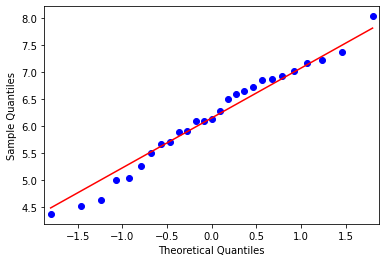

In [11]:
#Comprobación gráfica de normalidad
# q-q plot

qqplot(depModelTonnLog, line='s')

plt.show()

In [12]:
# normality test

'''
Statistic: A quantity calculated by the test that can be interpreted in the context of the test via comparing 
it to critical values from the distribution of the test statistic.
p-value: Used to interpret the test, in this case whether the sample was drawn from a Gaussian distribution.

'''

stat, p = shapiro(depModelTonnLog)

print('Estadístico=%.3f, p=%.3f' % (stat, p))

# interpret

alpha = 0.05

if p > alpha:
    cprint('Según Shapiro-Wilks la muestra parece tener distribución Gaussiana (NO se desecha la Hipótesis Nula)','red',  attrs=['bold'])
else:
    cprint('Según Shapiro-Wilk la muestra NO parece tener distribución Gaussiana (se desecha la Hipótesis Nula)','red',  attrs=['bold'])

Estadístico=0.975, p=0.748


NameError: name 'cprint' is not defined

If the p value is less than the chosen alpha level, then the null hypothesis is rejected and there is evidence that the data tested are not normally distributed. On the other hand, if the p value is greater than the chosen alpha level, then the null hypothesis that the data came from a normally distributed population can not be rejected (e.g., for an alpha level of .05, a data set with a p value of less than .05 rejects the null hypothesis that the data are from a normally distributed population).

Like most statistical significance tests, if the sample size is sufficiently large this test may detect even trivial departures from the null hypothesis (i.e., although there may be some statistically significant effect, it may be too small to be of any practical significance); thus, additional investigation of the effect size is typically advisable, e.g., a Q–Q plot in this case. (from Wikipedia)

p-values are very dependent on sample sizes. With a large sample, almost anything desviation can be significant.

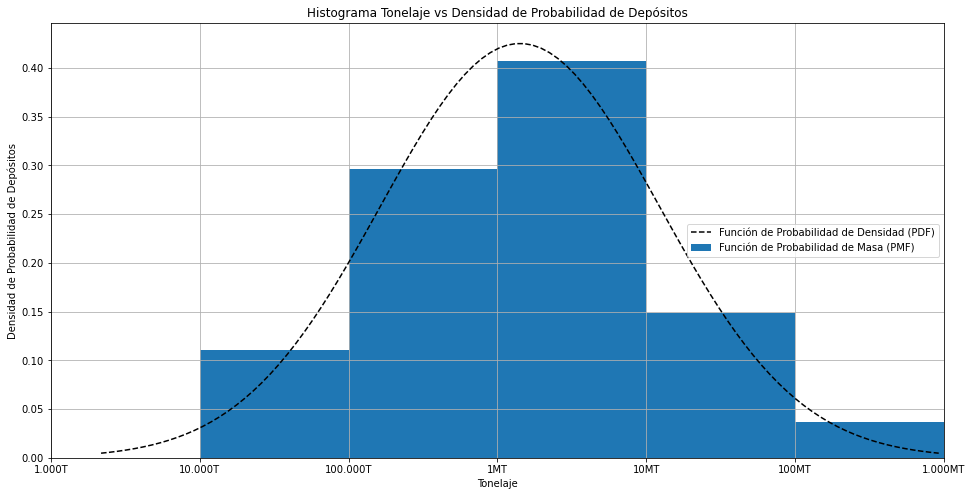

In [13]:
#n_bins = freedman_diaconis(depModelTonnLog, returnas='bins')


x_min = depModelTonnLogMean - depModelTonnLogStd * 3
x_max = depModelTonnLogMean + depModelTonnLogStd * 3

x = np.linspace(x_min, x_max, 100)

depNormPdf = norm.pdf(x, depModelTonnLogMean, depModelTonnLogStd)


fig, ax = plt.subplots(figsize=(16,8))

ax.set_xlim((x_min, x_max))

# Overlay a reversed cumulative histogram.

ax.hist(depModelTonnLog, 
        #bins=n_bins,
        bins=[3,4,5,6,7,8,9],
        density=True, 
        histtype='stepfilled', 
        cumulative=0,
        label='Función de Probabilidad de Masa (PMF)'
       )


ax.plot(x, depNormPdf, label='Función de Probabilidad de Densidad (PDF)', color='black', linestyle='dashed')

# tidy up the figure
ax.grid(True)
ax.legend(loc='right')
ax.set_title('Histograma Tonelaje vs Densidad de Probabilidad de Depósitos')
ax.set_xlabel('Tonelaje')
ax.set_ylabel('Densidad de Probabilidad de Depósitos')

currentXticks = [3,4,5,6,7,8,9]

xTickLabelLst = ['1.000T', '10.000T', '100.000T', '1MT', '10MT', '100MT', '1.000MT']

plt.xticks(currentXticks, xTickLabelLst)
    

plt.show()

In [14]:
#Calculo del rango de tonelage entre log percentil 10 y 90
depModelTonnLog10p2Dec = 10 ** depModelTonnLog10p
depModelTonnLog90p2Dec = 10 ** depModelTonnLog90p

print(f"El 80% de los tonelages se encuentran entre {depModelTonnLog10p2Dec:,.0f} y  {depModelTonnLog90p2Dec:,.0f} T")
print(f'El valor medio será de {depModelTonnLogMean2dec:,.2f} T')

El 80% de los tonelages se encuentran entre 71,349 y  15,388,527 T
El valor medio será de 1,414,640.95 T


In [15]:
depModelTonnPob

minVal, maxVal = (9,10)

a = np.extract(depModelTonnLog < maxVal, depModelTonnLog)
b = np.extract(a > minVal,a)
len(b)


0

**Habria que hacer el análisis de Normalidad a las Leyes**

In [16]:
depModelTonnLog

0     6.929419
1     5.705864
2     7.230449
3     5.498311
4     7.012837
5     6.725095
6     6.591065
7     6.089905
8     6.857332
9     7.158362
10    5.000000
11    5.908485
12    4.380211
13    6.139879
14    4.633468
15    5.677607
16    6.283301
17    5.884229
18    8.029384
19    5.267172
20    6.643453
21    5.045323
22    6.510545
23    7.365488
24    6.877947
25    4.518514
26    6.103804
Name: tonn, dtype: float64

## Estadísticos para  Menas (Au, Ag)

In [17]:
#Habria que hacer el test de normalidad para aplicar este criterio

print(f"Población: {depModelTonnPob} Total")
print()

varDict = {}

for mena in menasLst:
    varDict["Log" + mena]          = np.log10(depModelDF.loc[depModelDF[mena] > 0 ][mena])
    varDict["LogTonn" + mena]      = np.log10(depModelDF.loc[depModelDF[mena] > 0 ]['tonn'])
    
    varDict[mena + "Pob "]         = varDict["Log" + mena].size

    varDict["Log" + mena + "Min"]  = varDict["Log" + mena].min()
    varDict["Log" + mena + "Max"]  = varDict["Log" + mena].max()
    varDict["Log" + mena + "Mean"] = np.mean(varDict["Log" + mena])
    varDict["Log" + mena + "Std"]  = np.std(varDict["Log" + mena])
    
   
    varDict["Log" + mena + "10p"]  = np.percentile(varDict["Log" + mena], 10)
    varDict["Log" + mena + "50p"]  = np.percentile(varDict["Log" + mena], 50)
    varDict["Log" + mena + "90p"]  = np.percentile(varDict["Log" + mena], 90)
    p10 = varDict["Log" + mena + "10p"]
    p50 = varDict["Log" + mena + "50p"]
    p90 = varDict["Log" + mena + "90p"]
   
    print(f"Estadísticos del Log {mena}")
    print()
    print(f"Población de {mena}: %s" % (varDict[mena + "Pob "]))
    print("Min: %s" % (varDict["Log" + mena + "Min"]))
    print("Max: %s" % (varDict["Log" + mena + "Max"]))
    print("Mean: %s" % (varDict["Log" + mena + "Mean"]))
    print("Std: %s" % (varDict["Log" + mena + "Std"]))
    print(f"Percentiles 10%: {p10:.5f} 50%: {p50:.5f} (mediana) 90%: {p90:.5f}")
    print()
    print()
    
    
    #para pasar de % a gramos por tonelada hay que multiplicar por 10.000

Población: 27 Total

Estadísticos del Log Au

Población de Au: 23
Min: -4.698970004336019
Max: -2.494850021680094
Mean: -3.6734526860559655
Std: 0.5744718114874365
Percentiles 10%: -4.52288 50%: -3.65758 (mediana) 90%: -2.97999


Estadísticos del Log Ag

Población de Ag: 27
Min: -2.958607314841775
Max: -0.8664610916297825
Mean: -1.901036973399897
Std: 0.46776846661629073
Percentiles 10%: -2.38665 50%: -1.91721 (mediana) 90%: -1.26030


Estadísticos del Log Cu

Población de Cu: 19
Min: -1.3979400086720375
Max: 0.36172783601759284
Mean: -0.5253585248193842
Std: 0.47142343839717943
Percentiles 10%: -1.00000 50%: -0.60206 (mediana) 90%: 0.12224


Estadísticos del Log Pb

Población de Pb: 25
Min: -0.6989700043360187
Max: 0.9030899869919435
Mean: 0.36134882313999817
Std: 0.34065259059905245
Percentiles 10%: 0.01656 50%: 0.36173 (mediana) 90%: 0.81832




## Correlación entre Tonelaje y Ley
Habría que poner el cuadro en una escala correcta para comparación

### Correlación

In [18]:
varCorrDict = {}

for mena in menasLst:
    varCorrDict["covarianceTonn" + mena] = np.cov(varDict["LogTonn" + mena],varDict["Log" + mena]) #Calculo de la MATRIZ de covarianza

    '''
     Coeficiente de Correlación de Pearson
     It is the normalization of the covariance between the two variables to give an interpretable score.
     Pearson's correlation coefficient = covariance(X, Y) / (stdv(X) * stdv(Y))
    '''
    corr, p  = pearsonr(varDict["LogTonn" + mena],varDict["Log" + mena])

    print(f"Correlación Tonelaje - {mena}")
    print(f"El coficiente de correlación de Pearson es de: {corr:.2f}")
    print(f"El valor calculado de p es de : {p:.4f}")

    print()

    if corr > 0:
        cprint("La relación tiene pendiente positiva",'red',  attrs=['bold'])
    else:
        cprint("La relación tiene pendiente negativa",'red',  attrs=['bold'])
    
    
    # Esto habría que definirlo en términos de clasificación fuzzy

    if abs(corr) > 0.5 :
        cprint("El índice de correlación parece indicar que la misma es fuerte.",'red',  attrs=['bold'])
    elif abs(corr) <= 0.5 and abs(corr) > 0:
        cprint("El índice de correlación parece indicar que la misma es débil.",'red',  attrs=['bold'])
    elif corr == 0:
        cprint("El índice define que no hay correlación.",'red',  attrs=['bold'])
        
    if p > 0.05 :
        cprint("Para un nivel de significancia igual a 0.05, la correlación NO es estadísticamente significativa.",'red',  attrs=['bold'])
    elif p <= 0.05 :
        cprint("Para un nivel de significancia igual a 0.05, la correlación es estadísticamente significativa.",'red',  attrs=['bold'])
   
    print()
    print()

Correlación Tonelaje - Au
El coficiente de correlación de Pearson es de: -0.37
El valor calculado de p es de : 0.0794



NameError: name 'cprint' is not defined

In [19]:
# Regression
for mena in menasLst:
    slope, intercept, r, p, stderr = stats.linregress(varDict["LogTonn" + mena],varDict["Log" + mena])

    line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'
    print(mena)
    print(line)
    print()

Au
Regression line: y=-2.12+-0.25x, r=-0.37

Ag
Regression line: y=-2.16+0.04x, r=0.08

Cu
Regression line: y=0.97+-0.24x, r=-0.42

Pb
Regression line: y=1.69+-0.22x, r=-0.58



y=-2.09+-0.18x, r=-0.33

Valor teórico del Ley/Grado para el tonelaje dado

10 <sup>-( 2,09 + 0,18 * log10(9.840.000))</sup>= 0,000447982 %

### Diagrama de Disperción

NameError: name 'confidence_ellipse' is not defined

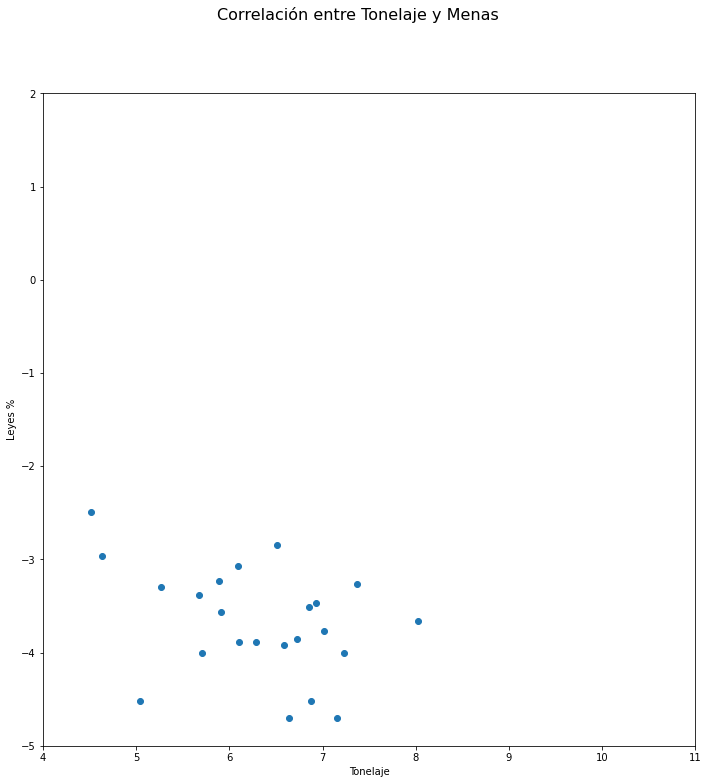

In [20]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

##
#Hay que hacer varios subplots
##

fig, axScatter = plt.subplots(figsize=(12,12))


axScatter.set_aspect(1.)
fig.suptitle('Correlación entre Tonelaje y Menas', fontsize=16)

axScatter.set_xlabel('Tonelaje')
axScatter.set_ylabel('Leyes %')
axScatter.set_xlim((4, 11))
axScatter.set_ylim((-5, 2 ))

# the scatter plot:
for mena in menasLst:
    axScatter.scatter(varDict["LogTonn" + mena],varDict["Log" + mena], label=mena)
    confidence_ellipse(varDict["LogTonn" + mena],varDict["Log" + mena], axScatter, 2, edgecolor='red')

    #Regression
    #axScatter.plot(LSQVLog, intercept + slope * LSQVLog, label=line) #Hay diferencias entre la ellipse y la regresion
 
#formateo de ticks
plt.sca(axScatter)

currentXticks = [4,5,6,7,8,9,10,11]

xTickLabelLst = ['10.000T', '100.000T', '1MT', '10MT', '100MT', '1.000MT', '10.000MT', '100.000MT']

plt.xticks(currentXticks, xTickLabelLst)
    
currentYticks = [-5, -4, -3, -2, -1, 0 ,1 , 2, 3, 4]
yTickLabelLst = ['0,00001%', '0,0001%', '0,001%', '0,01%', '0,1%', '1%', '10%', '100%', '1000%', '10000%']
    
plt.yticks(currentYticks, yTickLabelLst)
    
plt.legend(loc='right')

plt.show()

### Hay que ver bien como se definen los limites de y y en que unidades

Hay que dibujar la función de correlación y los parámetros
A la función de correlación se le dibuja el intervalo de confidencia que según singer puede ser 80%
Para el caso de que no haya correlación hay que definir un umbral para que no se dibuje

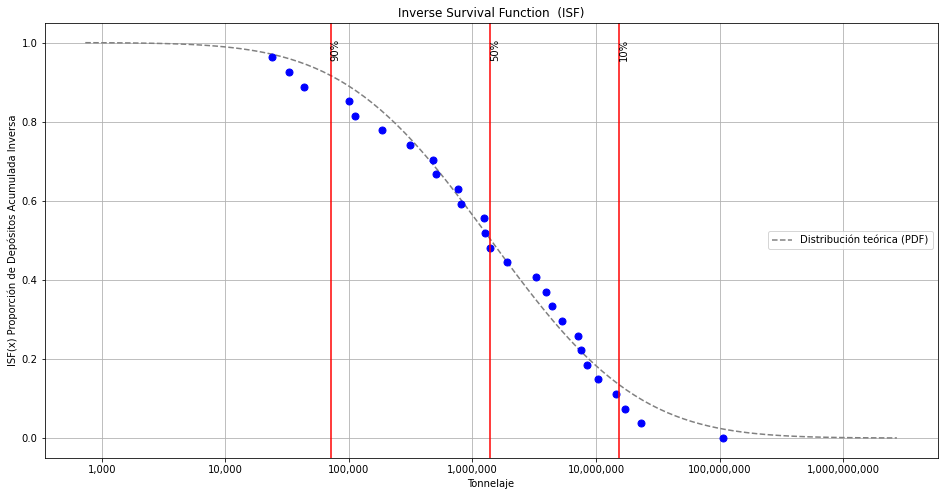

In [21]:
n_bins = 50


fig, ax = plt.subplots(figsize=(16,8))

# Overlay a reversed cumulative histogram.
#n, bins, patches = ax.hist(depModelTonnLog, bins=n_bins, density=True, histtype='step', cumulative=-1, label='Tonelage')

xMax = depModelTonnLogMean + 3.5 * depModelTonnLogStd
xMin = depModelTonnLogMean - 3.5 * depModelTonnLogStd

x = np.linspace(xMin, xMax, 100)
ax.plot(x, norm.sf(x, depModelTonnLogMean, depModelTonnLogStd), label='Distribución teórica (PDF)', color='gray', linestyle='dashed')


depModelTonnLog.sort_values(inplace=True)
n = depModelTonnLog.size
y = [ 1 - (np.arange(1, n+1) / n)]


ax.plot([depModelTonnLog], y, marker='o', markersize=7, color='blue')
    

ax.axvline(x=depModelTonnLog10p, color='r')
ax.text(depModelTonnLog10p,1-0.04,'90%',rotation=90)

ax.axvline(x=depModelTonnLog50p, color='r')
ax.text(depModelTonnLog50p,1-0.04,'50%',rotation=90)

ax.axvline(x=depModelTonnLog90p, color='r')
ax.text(depModelTonnLog90p,1-0.04,'10%',rotation=90)

# tidy up the figure
ax.grid(True)
ax.legend(loc='right')
ax.set_title('Inverse Survival Function  (ISF)')
ax.set_xlabel('Tonnelaje')
ax.set_ylabel('ISF(x) Proporción de Depósitos Acumulada Inversa')

#renombrar xticks
xTicksLst    = [i for i in range(round(xMin), round(xMax) + 1)]
xTicksLabels = ['{:,.0f}'.format(10 ** x) for x in  xTicksLst]
ax.set_xticks(xTicksLst)  # Get the current locations and labels.
ax.set_xticklabels(xTicksLabels)


plt.show()

## Proporción de Tonelajes

In [22]:
# Calculamos la proporción de yacimientos para cada intervalo
# 0-10.000t-1.000.000-10.000.000-más de 10.000.000

#depModelPob Tamaño de la población


In [23]:
TonnLT100K       = depModelDF.loc[(depModelDF['tonn'] < 100000)]
TonnGT100KLT1M   = depModelDF.loc[(depModelDF['tonn'] > 100000)  & (depModelDF['tonn'] < 1000000) ]
TonnGT1MLT10MT   = depModelDF.loc[(depModelDF['tonn'] > 1000000) & (depModelDF['tonn'] < 10000000) ]
TonnGT10MLT100MT = depModelDF.loc[(depModelDF['tonn'] > 10000000) & (depModelDF['tonn'] < 100000000)]
TonnGT100MT      = depModelDF.loc[(depModelDF['tonn'] > 100000000)]

TonnLT100Ks       = TonnLT100K['tonn'].size
TonnGT100KLT1Ms   = TonnGT100KLT1M['tonn'].size
TonnGT1MLT10MTs   = TonnGT1MLT10MT['tonn'].size
TonnGT10MLT100MTs = TonnGT10MLT100MT['tonn'].size
TonnGT100MTs      = TonnGT100MT['tonn'].size

tonnProp        = pd.DataFrame({
                              'Tonelaje': ['<100KT', '100KT-1MT','1MT-10MT', '10MT-100MT', '>100MT'],
                              'numYac': [TonnLT100Ks, TonnGT100KLT1Ms,TonnGT1MLT10MTs, TonnGT10MLT100MTs, TonnGT100MTs ],
                              'Au min%': [TonnLT100K['Au'].min(), TonnGT100KLT1M['Au'].min(),TonnGT1MLT10MT['Au'].min(), TonnGT10MLT100MT['Au'].min(), TonnGT100MT['Au'].min()],
                              'Au max%': [TonnLT100K['Au'].max(), TonnGT100KLT1M['Au'].max(),TonnGT1MLT10MT['Au'].max(), TonnGT10MLT100MT['Au'].max(), TonnGT100MT['Au'].max()],
                              'Au mean%': [TonnLT100K['Au'].mean(), TonnGT100KLT1M['Au'].mean(),TonnGT1MLT10MT['Au'].mean(), TonnGT10MLT100MT['Au'].mean(), TonnGT100MT['Au'].mean()],
                              'Au mean g/T': [percent2gramTonne(TonnLT100K['Au'].mean()), percent2gramTonne(TonnGT100KLT1M['Au'].mean()),percent2gramTonne(TonnGT1MLT10MT['Au'].mean()), percent2gramTonne(TonnGT10MLT100MT['Au'].mean()), percent2gramTonne(TonnGT100MT['Au'].mean())],
                              'Ag min%': [TonnLT100K['Ag'].min(), TonnGT100KLT1M['Ag'].min(),TonnGT1MLT10MT['Ag'].min(), TonnGT10MLT100MT['Ag'].min(), TonnGT100MT['Ag'].min()],
                              'Ag max%': [TonnLT100K['Ag'].max(), TonnGT100KLT1M['Ag'].max(),TonnGT1MLT10MT['Ag'].max(), TonnGT10MLT100MT['Ag'].max(), TonnGT100MT['Ag'].max()],
                              'Ag mean%': [TonnLT100K['Ag'].mean(), TonnGT100KLT1M['Ag'].mean(),TonnGT1MLT10MT['Ag'].mean(), TonnGT10MLT100MT['Ag'].mean(), TonnGT100MT['Ag'].mean()],
                              'Ag mean g/T': [percent2gramTonne(TonnLT100K['Ag'].mean()), percent2gramTonne(TonnGT100KLT1M['Ag'].mean()),percent2gramTonne(TonnGT1MLT10MT['Ag'].mean()), percent2gramTonne(TonnGT10MLT100MT['Ag'].mean()), percent2gramTonne(TonnGT100MT['Ag'].mean())],
                              'Probabilidad': [TonnLT100Ks/depModelPob, TonnGT100KLT1Ms/depModelPob,TonnGT1MLT10MTs/depModelPob, TonnGT10MLT100MTs/depModelPob, TonnGT100MTs/depModelPob ]})


NameError: name 'percent2gramTonne' is not defined

In [24]:
tonnProp

NameError: name 'tonnProp' is not defined

# EDA DEL YACIMIENTO

## Datos del Yacimiento a Estudiar

The current resource contains 9.84 million tonnes at 2.36 g/t AuEq for 746,000 oz in the Indicated category and a further

In [25]:
depName = 'Calcatreu v49-Nelson'
calcatreuIndicTonn = 7.83 * 10 ** 6
calcatreuAu        = 2.28
calcatreuAg        = 20.29

castroSurIndicTonn = 2.010 * 10 ** 6
castroSurAu        = 1.40
castroSurAg        = 14.77

calcatreuIndicLogTonn = np.log10(calcatreuIndicTonn)
calcatreuLogAu        = np.log10(calcatreuAu /10000) #g/t a %

castroSurIndicLogTonn = np.log10(castroSurIndicTonn)
castroSurLogAu        = np.log10(castroSurAu / 10000)
castroSurLogAg        = np.log10(castroSurAg)

print('Calcatreu v49')
print(calcatreuIndicLogTonn)
print(f"{calcatreuLogAu}%")

print()

print('Castro Sur')
print(castroSurIndicLogTonn)
print(castroSurLogAu)

Calcatreu v49
6.893761762057943
-3.642065152999546%

Castro Sur
6.303196057420489
-3.853871964321762


In [26]:
LSQVLogRandom = random.normal(loc=LSQVLogMean, scale=LSQVLogStd, size=(100000))


n_bins = 50
n_bins=freedman_diaconis(LSQVLog, returnas="bins")

fig, ax = plt.subplots(figsize=(16,8))

# Overlay a reversed cumulative histogram.
ax.hist(LSQVLog, 
        bins=n_bins, 
        density=True, 
        histtype='stepfilled', 
        cumulative=0,
        label='Función de Probabilidad de Masa (PMF)'
       )

xMax = LSQVLogMean + 3.5 * LSQVLogStd
xMin = LSQVLogMean - 3.5 * LSQVLogStd
x = np.linspace(xMin, xMax, 100)
ax.plot(x, norm.pdf(x, LSQVLogMean, LSQVLogStd), label='Distribución teórica (PDF)', color='black', linestyle='dashed')


#Yacimiento

#Valor del yacimiento en la funcion de probabilidad
zYac = norm.pdf(calcatreuIndicLogTonn, LSQVLogMean, LSQVLogStd) 
ax.plot([calcatreuIndicLogTonn], [zYac], marker='o', markersize=5, color='red')
ax.text(calcatreuIndicLogTonn, zYac +.015,'Calcatreu',rotation=90)
#/Yacimiento


ax.axvline(x=LSQVLog10p, color='r')
ax.text(LSQVLog10p,-0.04,'10%',rotation=90)

ax.axvline(x=LSQVLog50p, color='r')
ax.text(LSQVLog50p,-0.04,'50%',rotation=90)

ax.axvline(x=LSQVLog90p, color='r')
ax.text(LSQVLog90p,-0.04,'90%',rotation=90)

# tidy up the figure
ax.grid(True)
ax.legend(loc='right')
ax.set_title('Histograma Transformada Log 10')
ax.set_xlabel('Log Tonn ')
ax.set_ylabel('Proporción de Depósitos')
#ax.set_xscale('log')

plt.show()

NameError: name 'LSQVLogMean' is not defined

Percentiles calculados en base a la muestra

In [27]:
print(f'Probabilidad de ocurrencia: {zYac:.3f}')

NameError: name 'zYac' is not defined

NameError: name 'LSQVLog' is not defined

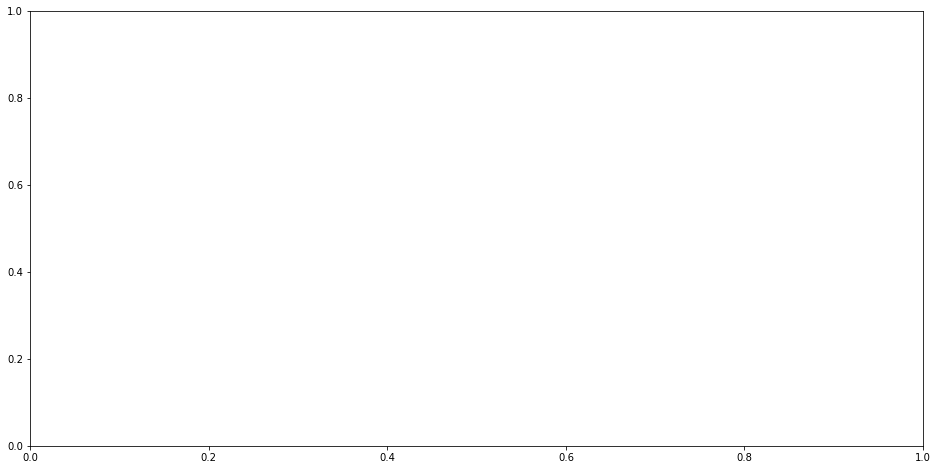

In [28]:
n_bins = 50


fig, ax = plt.subplots(figsize=(16,8))

# Overlay a reversed cumulative histogram.
n, bins, patches = ax.hist(LSQVLog, bins=n_bins, density=True, histtype='step', cumulative=-1,
        label='Tonelage')


x = np.linspace(xMin, xMax, 100)
ax.plot(x, norm.sf(x, LSQVLogMean, LSQVLogStd), label='Distribución teórica (PDF)', color='gray', linestyle='dashed')


ax.plot([calcatreuIndicLogTonn], [zYac], marker='o', markersize=5, color='red')
ax.text(calcatreuIndicLogTonn, zYac +.02,'Calcatreu',rotation=90)

LSQVLog.sort_values(inplace=True)
n = LSQVLog.size
y = [ 1 - (np.arange(1, n+1) / n)]


ax.plot([LSQVLog], y, marker='o', markersize=7, color='blue')
    

ax.axvline(x=LSQVLog10p, color='r')
ax.text(LSQVLog10p,1-0.04,'90%',rotation=90)

ax.axvline(x=LSQVLog50p, color='r')
ax.text(LSQVLog50p,1-0.04,'50%',rotation=90)

ax.axvline(x=LSQVLog90p, color='r')
ax.text(LSQVLog90p,1-0.04,'10%',rotation=90)


# tidy up the figure
ax.grid(True)
ax.legend(loc='right')
ax.set_title('Inverse Survival Function  (ISF)')
ax.set_xlabel('Tonnelaje (escala log 10))')
ax.set_ylabel('ISF(x) Proporción de Depósitos Acumulada Inversa')

#renombrar xticks
xTicksLst    = [i for i in range(round(xMin), round(xMax) + 1)]
xTicksLabels = ['{:,.0f}'.format(10 ** x) for x in  xTicksLst]
ax.set_xticks(xTicksLst)  # Get the current locations and labels.
ax.set_xticklabels(xTicksLabels)


plt.show()

Percentiles calculados en base a la muestra

La inversa de la distribucion acumulada o Función de Supervivencia Inversa (ISF) nos indica  la chance de encontrar yacimientos mayores a un valor dado

## Leyes

In [ ]:
zGrade = norm.pdf(calcatreuLogAu, LSQVLogAuMean, LSQVLogAuStd)
print(f'Z Grade {zGrade:.2f}; Log Au: {calcatreuLogAu:.2f}')


In [ ]:
n_bins = 50


fig, ax = plt.subplots(figsize=(16,8))

# Overlay a reversed cumulative histogram.
n, bins, patches = ax.hist(LSQVLogAu, bins=n_bins, density=True, histtype='step', cumulative=-1,
        label='Low Suphidation Au Qrtz Veins')

xMax = LSQVLogAuMean + 3.5 * LSQVLogAuStd
xMin = LSQVLogAuMean - 3.5 * LSQVLogAuStd

x = np.linspace(xMin, xMax, 100)


ax.plot(x, norm.sf(x, LSQVLogAuMean, LSQVLogAuStd), 
        label='Distribución teórica', color='gray', linestyle='dashed')

#zYac = norm.pdf(calcatreuIndicLogTonn, LSQVLogMean, LSQVLogStd) 

#zGrade = norm.pdf(calcatreuLogAu, LSQVLogAuMean, LSQVLogAuStd)

#ax.plot([calcatreuLogAu], [zGrade], marker='o', markersize=5, color='red')
#ax.text(calcatreuLogAu, zGrade +.02,'Calcatreu',rotation=90)

ax.axvline(x=LSQVLogAu10p, color='r')
ax.text(LSQVLogAu10p,-0.04,'90%',rotation=90)

ax.axvline(x=LSQVLogAu50p, color='r')
ax.text(LSQVLogAu50p,-0.04,'50%',rotation=90)

ax.axvline(x=LSQVLogAu90p, color='r')
ax.text(LSQVLogAu90p,-0.04,'10%',rotation=90)


# tidy up the figure
ax.grid(True)
ax.legend(loc='right')
ax.set_title('Inverse Survival Function  (ISF)')
ax.set_xlabel('log(Au Grade) LS Au Q Veins')
ax.set_ylabel('ISF(x)')


plt.show()